In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from scipy import stats
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline
from arch import arch_model

/home/michael/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## 1. Loading in datasets

#### (a) Dataset for Credit Default Swap spreads

In [2]:
cds_DF = pd.read_csv("datasets/cds.csv", parse_dates=['Date'])
cds_DF.head()

,Date,Ticker,Company,PX1,PX2,PX3,PX4,PX5,PX6,PX7,PX8,PX9,PX10
0,2015-01-01,A,Agilent Technologies Inc,14.850,25.05,39.055,73.715,86.30,111.305,125.905,144.300,158.600,168.195
1,2015-01-02,A,Agilent Technologies Inc,14.855,25.15,39.160,73.600,86.40,111.510,126.100,144.375,158.775,168.375
2,2015-01-05,A,Agilent Technologies Inc,13.455,24.96,39.310,70.200,88.26,111.970,125.060,143.165,157.385,166.825
3,2015-01-06,A,Agilent Technologies Inc,15.535,24.88,39.300,72.680,91.10,116.610,130.890,150.365,165.655,175.885
4,2015-01-07,A,Agilent Technologies Inc,15.215,25.50,40.270,73.880,92.50,117.780,131.940,151.145,166.215,176.295


#### (b) Dataset for equities of different companies

In [3]:
comp_stocks_DF = pd.read_csv("datasets/company_stock_data.csv", index_col='Date', parse_dates=True)
comp_stocks_DF.head()

,A,AAPL,ABBV,ABT,ADM,ADP,AES,AFG,AGR,AIG,...,WEC,WELL,WFC,WHR,WM,WMB,WMT,WU,WY,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,37.422062,24.347172,43.563179,37.108746,39.133045,67.362991,9.684173,30.017288,NaN,44.253033,...,38.417412,51.027782,41.032391,135.059799,42.477646,25.322723,23.493425,11.352100,24.284630,60.042534
2015-01-05,36.720852,23.661274,42.743362,37.117004,37.778957,67.314476,9.408492,29.623707,NaN,43.377602,...,37.947937,51.657738,39.907192,132.274841,42.050804,24.320345,23.425055,11.244470,24.284630,58.399651
2015-01-06,36.148819,23.663500,42.531784,36.695503,37.034214,66.756416,9.196430,29.454308,NaN,42.762428,...,38.049053,52.393814,39.074547,131.183243,42.083641,23.989943,23.605558,11.225472,24.257740,58.089199
2015-01-07,36.628582,23.995317,44.250786,36.993034,37.590893,67.338745,9.210567,29.648619,NaN,42.967476,...,38.518543,52.877903,39.307091,134.269150,42.116470,23.861147,24.231873,11.117839,24.331717,58.677792
2015-01-08,37.726505,24.917271,44.713577,37.753399,37.041733,68.883507,9.351940,30.186687,NaN,42.778191,...,38.944660,52.659077,40.177235,137.732925,42.600754,24.090736,24.743311,11.339439,24.593996,59.654469


#### (c) Dataset for total asset value and total debt vale of companies

In [4]:
quarterly_DF = pd.read_csv("datasets/quarterly_company_data.csv", parse_dates=['datadate'])
quarterly_DF.head()

,gvkey,datadate,fyearq,fqtr,indfmt,consol,popsrc,datafmt,tic,cusip,...,costat,dvpspq,dvpsxq,mkvaltq,gind,gsector,gsubind,idbflag,naics,spcsrc
0,1078,2014-12-31,2014,4.0,INDL,C,D,STD,ABT,002824100,...,A,0.22,0.22,67891.7357,351010.0,35.0,35101010.0,B,334510,B+
1,1078,2015-03-31,2015,1.0,INDL,C,D,STD,ABT,002824100,...,A,0.24,0.24,68974.1118,351010.0,35.0,35101010.0,B,334510,B+
2,1078,2015-06-30,2015,2.0,INDL,C,D,STD,ABT,002824100,...,A,0.24,0.24,73150.8443,351010.0,35.0,35101010.0,B,334510,B+
3,1078,2015-09-30,2015,3.0,INDL,C,D,STD,ABT,002824100,...,A,0.24,0.24,59996.9784,351010.0,35.0,35101010.0,B,334510,B+
4,1078,2015-12-31,2015,4.0,INDL,C,D,STD,ABT,002824100,...,A,0.24,0.24,66137.3852,351010.0,35.0,35101010.0,B,334510,B+


#### (d) risk free rate series

In [5]:
risk_free_rate_S = web.DataReader('TB3MS', 'fred', start=quarterly_DF['datadate'].min().strftime('%Y-%m-%d'), 
                                  end=quarterly_DF['datadate'].max().strftime('%Y-%m-%d'))

## 2. Processing data

In [6]:
#load all used ticker names in a list.
with open('datasets/tickers.txt', 'r') as ticks:
    tickers = ticks.read().split('\n')[:-1]

In [7]:
#create a dictionary with ticker names and corresponding dataframe created by create_correct_dataframe()
ticks_DF_dict = {}
for tick in cds_DF.groupby('Ticker').size()[cds_DF.groupby('Ticker').size() >= 1747].index:
    if len(cds_DF[cds_DF['Ticker'] == tick]['PX1'].unique()) > 1000:
        ticks_DF_dict[tick] = cds_DF[cds_DF['Ticker'] == tick].set_index("Date")

## 3. Testing for stationarity

In [8]:
from statsmodels.tsa.stattools import adfuller

In [9]:
for tick, DF in ticks_DF_dict.items():
    dickey_test = adfuller(DF['PX1'])
    print(f"{tick}, t-stat:{dickey_test[0]:.5g}, p-val:{dickey_test[1]:.5g}")

A, t-stat:-2.26, p-val:0.18518
AALLN, t-stat:-3.2599, p-val:0.016771
AAPL, t-stat:-2.5887, p-val:0.095346
ABC, t-stat:-2.1598, p-val:0.22115
ABESM, t-stat:-3.2437, p-val:0.017592
ABIBB, t-stat:-3.8794, p-val:0.0021917
ABT, t-stat:-3.6921, p-val:0.0042254
ABXCN, t-stat:-2.6265, p-val:0.08765
ACAFP, t-stat:-3.121, p-val:0.02504
ACEIM, t-stat:-1.6213, p-val:0.47207
ACFP, t-stat:-1.7437, p-val:0.40875
ADENVX, t-stat:-2.27, p-val:0.18183
ADM, t-stat:-2.936, p-val:0.041321
ADNA, t-stat:-3.8225, p-val:0.0026849
ADP, t-stat:-1.9643, p-val:0.30243
ADSGR, t-stat:-1.6207, p-val:0.47235
AEGON, t-stat:-3.0901, p-val:0.027292
AES, t-stat:-2.6733, p-val:0.078775
AET, t-stat:-2.7918, p-val:0.059461
AFG, t-stat:-1.1872, p-val:0.67906
AGSBB, t-stat:-3.1247, p-val:0.024779
AIFP, t-stat:-2.8043, p-val:0.057661
AIG, t-stat:-4.511, p-val:0.0001878
AIRFP, t-stat:-2.6184, p-val:0.089263
AKZANA, t-stat:-3.9824, p-val:0.0015054
ALL, t-stat:-3.4435, p-val:0.0095639
ALLRNV, t-stat:-1.8654, p-val:0.34849
ALLY, t-s

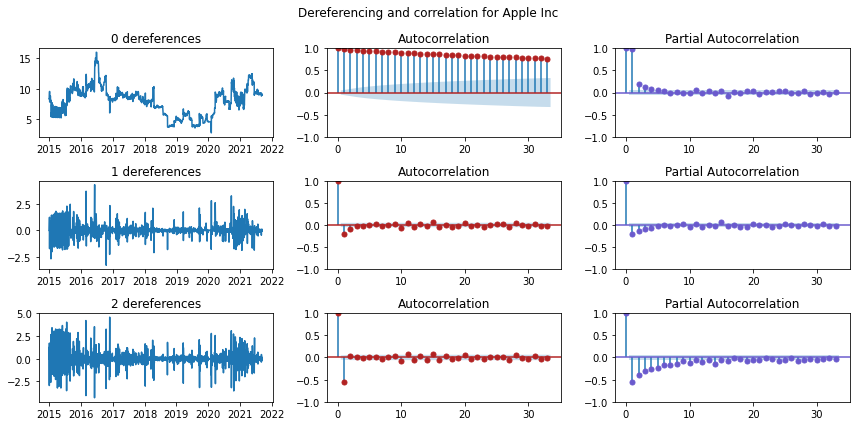

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
def plotOSandAC(tDF, dereferences, colname, type="BOTH"):
    """Plots the (dereferenced) series vs the autocorrelation, to see what amount of dereferencing
    is needed before the time-series is stationary."""
    assert dereferences > 0, "Amount of dereferences must be greater than 0"
    assert type in ['ACF', 'PACF', 'BOTH'], "Plot-type must be one of: 'PACF' or 'ACF' 'BOTH'"
    
    am_vertical_subplots = min(3, dereferences+1)
    am_horizontal_subplots = 2
    if type == 'BOTH':
        am_horizontal_subplots = 3
    
    fig, axes = plt.subplots(am_vertical_subplots, am_horizontal_subplots, figsize=(4*am_horizontal_subplots,2*am_vertical_subplots))
    for i in range(am_vertical_subplots):
        temp_tseries = tDF[colname]
        for amount_dereferencing in range(dereferences - (am_vertical_subplots-1-i)):
            temp_tseries = temp_tseries.diff().dropna()
        axes[i, 0].plot(temp_tseries); axes[i, 0].set_title(f'{dereferences - (am_vertical_subplots-1-i)} dereferences')
        if type == "ACF":
            plot_acf(temp_tseries, ax=axes[i, 1], color='firebrick')
        elif type == "PACF":
            plot_pacf(temp_tseries, ax=axes[i, 1], color='slateblue')
        elif type == "BOTH":
            plot_acf(temp_tseries, ax=axes[i, 1], color='firebrick')
            plot_pacf(temp_tseries, ax=axes[i, 2], color='slateblue')
    fig.suptitle(f"Dereferencing and correlation for {tDF.Company.iloc[0]}")
    plt.tight_layout()

plotOSandAC(ticks_DF_dict['AAPL'], 2, 'PX1', type="BOTH")

## 4. Fitting model on apple to look at distribution of residuals

In [11]:
from statsmodels.tsa.arima.model import ARIMA

# 1,1,1 ARIMA Model
model = ARIMA(ticks_DF_dict['AAPL']['PX1'].asfreq(freq='B', method='bfill'), order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    PX1   No. Observations:                 1747
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1198.268
Date:                Wed, 11 Dec 2024   AIC                           2402.536
Time:                        00:31:06   BIC                           2418.932
Sample:                    01-01-2015   HQIC                          2408.598
                         - 09-10-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4171      0.048      8.671      0.000       0.323       0.511
ma.L1         -0.6603      0.044    -15.169      0.000      -0.746      -0.575
sigma2         0.2310      0.003     80.846      0.0

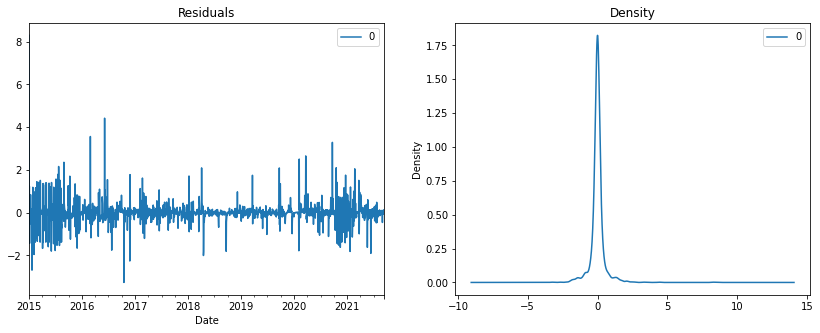

In [12]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(14,5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

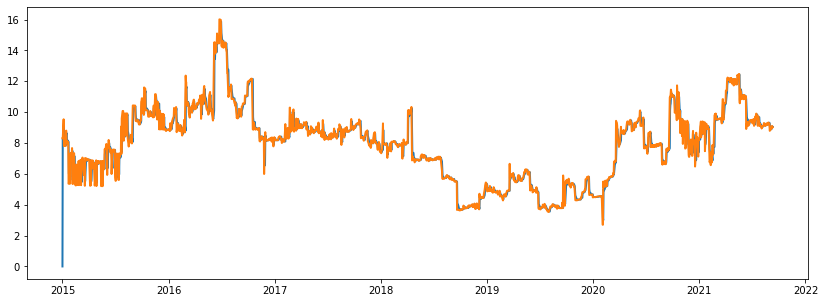

In [13]:
# Actual vs Fitted
from statsmodels.graphics.tsaplots import plot_predict
plt.figure(figsize=(14,5))
plt.plot(model_fit.predict(), alpha=1, linewidth=2)
plt.plot(ticks_DF_dict['AAPL']['PX1'], alpha=1, linewidth=2)# Set `dynamic=True` for dynamic forecasts
plt.show()

## 5. Defining functions to perform two simple forecasting methods

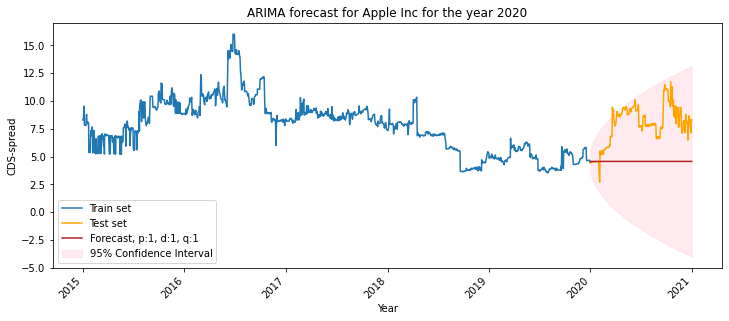

In [14]:
def SimpleARIMA(tDF, test_year, colname, plot=True, order=False):
    from pmdarima import auto_arima
    from statsmodels.tsa.arima.model import ARIMA
    train_set = tDF[tDF.index.year < test_year][colname].asfreq(freq='B', method='bfill')
    test_set  = tDF[tDF.index.year == test_year][colname].asfreq(freq='B', method='bfill')

    if not order: #Select best p, d and q based on AIC fitting
        auto_model = auto_arima(train_set, seasonal=False, trace=False)
        order = auto_model.order
        model_fit = ARIMA(train_set, order=order).fit()
    else:
        model_fit = ARIMA(train_set, order=order).fit()
    
    fc = model_fit.get_forecast(len(test_set)) 
    summary = fc.summary_frame()
    summary['actual'] = test_set
    
    if plot==True:
        fig = plt.figure(figsize=(12,5))
        plt.plot(train_set, label="Train set")
        plt.plot(test_set, color='orange', label="Test set")
        plt.plot(fc.predicted_mean.index, fc.predicted_mean, label=f'Forecast, p:{order[0]}, d:{order[1]}, q:{order[2]}', color='firebrick')
        
        plt.fill_between(
            fc.predicted_mean.index,
            fc.conf_int(alpha=0.05).iloc[:, 0],
            fc.conf_int(alpha=0.05).iloc[:, 1],
            color='pink', alpha=0.3, label='95% Confidence Interval'
        )
    
        fig.autofmt_xdate(rotation=45)
        plt.xlabel("Year")
        plt.ylabel("CDS-spread")
        plt.title(f"ARIMA forecast for {tDF.Company.iloc[0]} for the year {test_year}")
        plt.legend()
        plt.show()
    return summary

frame = SimpleARIMA(ticks_DF_dict['AAPL'], 2020, "PX1")

In [15]:
display(frame)

PX1,mean,mean_se,mean_ci_lower,mean_ci_upper,actual
2020-01-01,4.527445,0.472910,3.600557,5.454332,4.4779
2020-01-02,4.549356,0.589178,3.394588,5.704123,4.4842
2020-01-03,4.558255,0.662094,3.260576,5.855935,4.4872
2020-01-06,4.561870,0.719651,3.151380,5.972360,4.5001
2020-01-07,4.563338,0.770001,3.054165,6.072512,4.4918
...,...,...,...,...,...
2020-12-25,4.564342,4.336703,-3.935439,13.064124,8.3362
2020-12-28,4.564342,4.344994,-3.951690,13.080375,7.1190
2020-12-29,4.564342,4.353270,-3.967910,13.096595,8.2532
2020-12-30,4.564342,4.361530,-3.984100,13.112784,8.1845


0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 

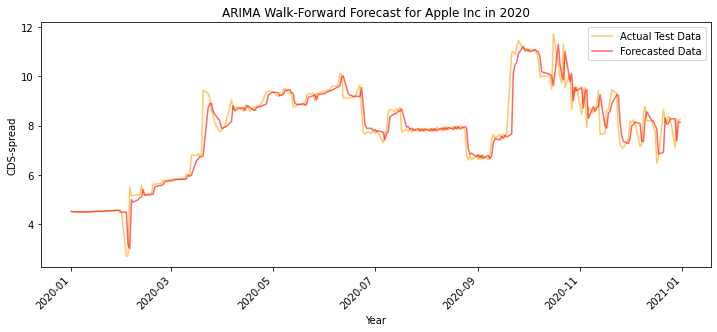

In [16]:
def WalkForwardARIMA(tDF, test_year, colname, order=False, plot=True):
    from pmdarima import auto_arima
    from statsmodels.tsa.arima.model import ARIMA

    # Train-test split
    train_set = tDF[tDF.index.year < test_year][colname].asfreq(freq='B', method='bfill')
    test_set  = tDF[tDF.index.year == test_year][colname].asfreq(freq='B', method='bfill')

    if not order: #Select best p, d and q based on AIC fitting
        auto_model = auto_arima(train_set, seasonal=False, trace=False)
        order = auto_model.order

    history = list(train_set)
    forecasts = []
    
    for i in range(len(test_set)):
        print(i, end=', ')

        model = ARIMA(history, order=order)
        model_fitted = model.fit()
        
        forecasted_value = model_fitted.forecast()[0]
        forecasts.append(forecasted_value)
        
        actual_value = test_set.iloc[i]
        history.append(actual_value)
    
    if plot==True:
        fig = plt.figure(figsize=(12,5))
        plt.plot(test_set.index, test_set, color='orange', alpha=0.6, label="Actual Test Data")
        plt.plot(test_set.index, forecasts, color='red', alpha=0.6, label="Forecasted Data")
        fig.autofmt_xdate(rotation=45)
        plt.xlabel("Year")
        plt.ylabel("CDS-spread")
        plt.title(f"ARIMA Walk-Forward Forecast for {tDF.Company.iloc[0]} in {test_year}")
        plt.legend()
        plt.show()
    return forecasts, test_set

preds, actual = WalkForwardARIMA(ticks_DF_dict['AAPL'], 2020, "PX1")


In [22]:
# Saving data to a csv file
results_df = pd.DataFrame({'Predictions': preds, 'Actual': actual})
results_df.to_csv('datasets/predictions_actual.csv', index=False)

## Metrics:

In [17]:
#Utilizing Parallel and delayed, otherwise it would take a very long time.
from joblib import Parallel, delayed
from pmdarima import auto_arima

def find_best_params(tDF, test_year, colname):
    train_set = tDF[tDF.index.year < test_year][colname].asfreq(freq='B', method='bfill')
    auto_model = auto_arima(train_set, seasonal=False, trace=False, max_p=3, max_d=2, max_q=3)
    order = auto_model.order
    return order

def parallel_fit_arima(ticks_DF_dict, test_year, colname):
    """Parallelized ARIMA fitting for multiple tickers."""
    results = Parallel(n_jobs=-1)(
        delayed(lambda tick, DF: (tick, find_best_params(DF, test_year, colname))) 
        (tick, DF)
        for tick, DF in ticks_DF_dict.items()
    )
    return dict(results)

# Call the parallel fitting function
order_dict = parallel_fit_arima(ticks_DF_dict, 2020, 'PX1')

/home/michael/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/michael/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/michael/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a 

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import mean_squared_error

RMSE_dict = dict()
for tick, DF in ticks_DF_dict.items():
    print(tick, end=', ')
    temp_frame = SimpleARIMA(DF, 2020, "PX1", order = order_dict[tick], plot=False)
    rmse = np.sqrt(mean_squared_error(temp_frame['mean'], temp_frame['actual']))
    RMSE_dict[tick] = rmse

A, AALLN, AAPL, ABC, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ABESM, ABIBB, ABT, ABXCN, ACAFP, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ACEIM, ACFP, ADENVX, ADM, ADNA, ADP, ADSGR, AEGON, AES, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AET, AFG, AGSBB, AIFP, AIG, AIRFP, AKZANA, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ALL, ALLRNV, ALLY, ALOFP, ALVGR, AMAT, AMGN, AMT, AMXLMM, AN, ANGSJ, ANTM, ANZ, APD, ARW, ASSABS, ASSGEN, ATCOA, ATLIM, AUCHAN, AVB, AVLN, AVT, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AVY, AXASA, AXP, AZN, AZO, BA, BAC, BACRED, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


BALN, BAMACN, BASGR, BATSLN, BAX, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


BAYNGR, BBDBCN, BBVAR, BBVASM, BBY, BCECN, BCHINA, BCJAF, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


BCPPL, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


BDX, BERTEL, BFCM, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


BHI, BK, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


BKIASM, BKIR, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


BKTSM, BLL, BMW, BMY, BNFP, BNFPL, BNKEA, BNP, BPLN, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


BRK, BSX, BWA, BYLAN, C, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


CAFP, CAG, CAH, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


CAPFP, CAR, CARGIL, CAT, CB, CBAAU, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


CCI, CDBLFD, CDEL, CECGR, CHMFRU, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


CI, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


CITNAT, CITOH, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


CL, CLX, CMACG, CMCSA, CMI, CMZB, CNALN, CNHI, CNOOC, CNP, CNQCN, CNRCN, CNUNZ, COF, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


COFP, COMQAT, CONGR, COP, COST, COXENT, CPB, CPGLN, CPT, CS, CSCO, CSX, CTVA, CVS, CVX, CXGD, D, DAIGR, DAIWA, DAL, DANBNK, DB, DBOERS, DE, DEPFA, DEVOBA, DGELN, DGFP, DGX, DHI, DHR, DOV, DOW, DPWDU, DPWGR, DRI, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


DSM, DT, DVN, DXC, DZBK, EBIUH, ED, EDF, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


EDPPL, EIBKOR, EMN, ENBCN, ENBW, ENELIM, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ENFP, ENGALL, ENGIFP, ENIIM, EOANGR, EOG, EQNR, ERICB, ERSTBK, ETEGA, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ETN, ETR, EVKGR, EWE, EXPE, F, FABUH, FCAIM, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


FDX, FFHCN, FREGR, FRFP, FRT, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


FTI, FUMVFH, GALPPL, GAZPRU, GD, GE, GFCFP, GIS, GLW, GM, GMGAU, GMT, GP, GS, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


GSK, GT, HAL, HAS, HCOB, HD, HEIANA, HEIGR, HENKEL, HES, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


HESLAN, HIG, HMSOLN, HNDA, HOFP, HON, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


HOTGR, HPQ, HSBC, HSECN, HSY, HTOGA, HUM, HYNMTR, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


HYSAN, HYUELE, IAGLN, IBESM, IBM, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ICICI, IMBLN, INDKOR, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


INEGRP, INTC, INTNED, INTU, INVSA, IP, IPG, ISPIM, ISRELE, ISSDC, ITVLN, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ITW, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


JAPTOB, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


JCI, JNJ, JNPR, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


JPM, JWN, K, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


KANSEL, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


KBCBB, KERFP, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


KIAMTR, KIM, KMB, KMI, KO, KORELE, KPN, KR, KSS, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


L, LBBW, LDOIM, LEN, LEVI, LGEN, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


LGFP, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LH, LHAGR, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LHNVX, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LIFP, LIFUNG, LMT, LNC, LOUDRE, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


LOW, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


LRFP, LUKOIL, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LUV, LXSGR, MAR, MARUB, MAS, MASQUH, MATSEL, MCD, MCFP, MCK, MDC, MDLZ, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MET, METSO, MHK, MITCO, MLM, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MMBFP, MMC, MMM, MMP, MO, MONTE, MOS, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MQGAU, MRK, MRKGR, MRO, MS, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MSFT, MSI, MTNA, MUBAUH, MUV2.DE, MWDP, NAB, NBL, NDASS, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


NDB, NEE, NEM, NESNVX, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


NGGLN, NKE, NNGRNV, NOC, NOKIA, NOMURA, NOVBNC, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


NOVNVX, NRG, NRUC, NSANY, NSC, NTGYSM, NUE, NVFVES, NVR, NWG, NWIDE, OC, ODGR, OKE, OMC, ORAFP, ORCL, ORIX, ORSTED, PAA, PEAK, PEMEX, PEP, PETBRA, PETMK, PEUGOT, PFE, PG, PGR, PHIANA, PHM, PKG, PM, PNC, POHANG, PPG, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


PROXBB, PRU, PRUFIN, PSMGR, PUBFP, PXD, QBEAU, R, RABOBK, RBIAV, RBOSGR, RCICN, RDSALN, REESM, REG, RELLN, RENAUL, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


REPSM, RIFP, RILIN, RL, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ROSNRM, RSG, RTOLN, RTX, RWE, RXLFP, SABIC, SABSM, SAMBA, SANFP, SANSCF, SANTAN, SANUK, SANUSA, SAPSJ, SBERRU, SBIIN, SCANIA, SCBGER, SCBNOR, SCMNVX, SCOR, SDFGR, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


SEB, SEE, SESGFP, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SFD, SFRFP, SGOFP, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


SGTOPT, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


SHBASS, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


SHIMAO, SHNHAN, SHW, SIBNEF, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SIEGR, SJNKI, SKENER, SKM, SLB, SLG, SMINLN, SO, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


SOCGEN, SOFTBK, SOLBBB, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SPGI, SRE, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SSELN, STANLN, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


STEDIN, STENA, STERV, STLA, STSP, STYRO, STZ, SUCN, SUFP, SUMI, SUMIFL, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SUNAU, SUNHUN, SWEDA, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


SWFP, SWIRE, SWK, SYNNVX, SYY, SZUGR, T, TAP, TCKBCN, TCN, TD, TDCDC, TELEFO, TELIAS, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


TELNO, TELVIS, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


TEVA, TGT, TITIM, TJX, TKAAV, TKAGR, TLSAU, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


TOTAL, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


TOYOTA, TRICN, TRV, TSCOLN, TSN, TT, TTEFP, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


TTMTIN, TXN, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


TXT, UBIIM, UCGIM, UDR, UHS, ULFP, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


UNBC, UNH, UNIIM, UNILAB, UNM, UNP, UPCB, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


UPMFH, UPS, URI, USB, UU, VALEBZ, VATFAL, VERAV, VFC, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


VIAC, VIEFP, VIVFP, VLO, VLVY, VMC, VOD, VW, VZ, WEC, WELL, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


WESAU, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


WFC, WHR, WKLNA, WM, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


WMB, WMT, 

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


WOORIB, WPLAU, WSTP, WU, WY, XL, XOM, 

In [ ]:
for tick, order in RMSE_dict.items():
    print(tick, order)

A 56.95306782026479
AALLN 38.92933569317075
AAPL 3.7591701062301084
ABC 1.750491960416859
ABESM 29.30104821082763
ABIBB 22.46899408410628
ABT 3.0051165861298523
ABXCN 2.2573747370580164
ACAFP 10.355155445881836
ACEIM 22.153949897334662
ACFP 90.41121788848484
ADENVX 4.6855867417504475
ADM 2.4871575706629563
ADNA 3.3621258416251565
ADP 2.3883314939977494
ADSGR 5.7538227085601825
AEGON 17.9962704702531
AES 37.51654526197404
AET 3.577076509615585
AFG 44.77116722052896
AGSBB 2.3114146897990215
AIFP 2.619323786475614
AIG 10.811071166367936
AIRFP 58.44433120660983
AKZANA 6.728062915519199
ALL 2.3609042811203604
ALLRNV 11.608512011555321
ALLY 69.52756485006651
ALOFP 4.306469744830166
ALVGR 6.927209082596513
AMAT 4.465716997201654
AMGN 3.0598627514911048
AMT 8.886145018886392
AMXLMM 47.67828308048819
AN 31.147406238863745
ANGSJ 80.80897037515848
ANTM 4.859110045931883
ANZ 8.683117782978377
APD 0.9559875934382674
ARW 4.288292852004465
ASSABS 1.7653945034879992
ASSGEN 26.503955897432622
ATCOA 11.

('BBDBCN', 1846.647718858478)


{'whiskers': [<matplotlib.lines.Line2D at 0x2408e941730>,
 'caps': [<matplotlib.lines.Line2D at 0x2408e941820>,
 'boxes': [<matplotlib.lines.Line2D at 0x2408e940d40>],
 'medians': [<matplotlib.lines.Line2D at 0x2408e941850>],
 'fliers': [<matplotlib.lines.Line2D at 0x2408e941940>],
 'means': []}

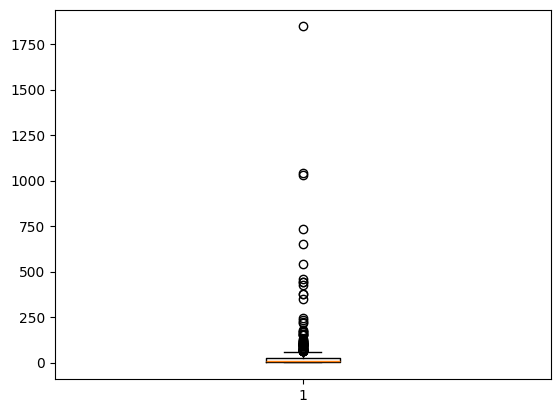

In [ ]:
plt.boxplot(RMSE_dict.values())

('BBDBCN', 1846.647718858478)


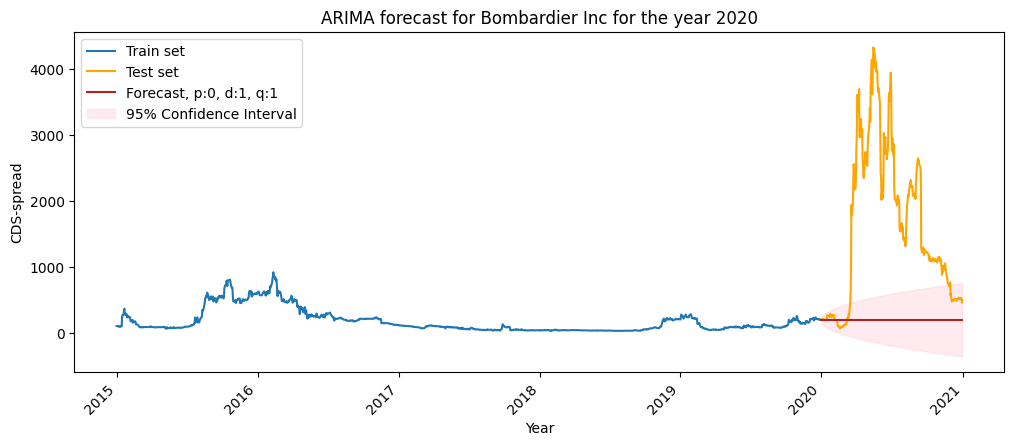

PX1,mean,mean_se,mean_ci_lower,mean_ci_upper,actual
2020-01-01,202.115791,19.966075,162.983003,241.248580,203.0812
2020-01-02,202.115791,26.572665,150.034325,254.197258,205.0051
2020-01-03,202.115791,31.836597,139.717209,264.514374,207.0976
2020-01-06,202.115791,36.345993,130.878953,273.352630,211.7276
2020-01-07,202.115791,40.354598,123.022232,281.209351,199.4693
...,...,...,...,...,...
2020-12-25,202.115791,281.809280,-350.220248,754.451831,522.9635
2020-12-28,202.115791,282.354268,-351.288405,755.519988,531.0087
2020-12-29,202.115791,282.898206,-352.354504,756.586087,503.3038
2020-12-30,202.115791,283.441100,-353.418557,757.650140,509.7409


In [ ]:
print(max(RMSE_dict.items(), key=lambda x: x[1]))
SimpleARIMA(ticks_DF_dict['BBDBCN'], 2020, "PX1", order = order_dict['F'], plot=True)

### getting fitted parameters to and from a .csv file

In [ ]:
#pd.DataFrame.from_dict(data=order_dict, columns=['p', 'd', 'q'], orient='index').to_csv('fitted_params_ARIMA.csv', header=True)

In [ ]:
orderDF = pd.read_csv('fitted_params_ARIMA.csv', index_col=0)
order_dict = {orderDF.iloc[i].name: (orderDF.iloc[i]['p'], orderDF.iloc[i]['d'], orderDF.iloc[i]['q']) for i in range(len(orderDF))}
for tick, order in order_dict.items():
    print(tick, order)

A (2, 1, 2)
AALLN (1, 1, 2)
AAPL (1, 1, 1)
ABC (3, 1, 2)
ABESM (2, 1, 3)
ABIBB (0, 1, 0)
ABT (1, 1, 1)
ABXCN (1, 1, 2)
ACAFP (3, 1, 3)
ACEIM (2, 1, 1)
ACFP (0, 1, 0)
ADENVX (1, 1, 2)
ADM (0, 1, 1)
ADNA (0, 1, 0)
ADP (1, 1, 1)
ADSGR (3, 1, 3)
AEGON (2, 1, 3)
AES (3, 1, 3)
AET (2, 1, 2)
AFG (0, 1, 2)
AGSBB (1, 1, 3)
AIFP (0, 1, 0)
AIG (3, 1, 2)
AIRFP (1, 1, 2)
AKZANA (3, 1, 2)
ALL (2, 1, 1)
ALLRNV (2, 1, 2)
ALLY (2, 1, 1)
ALOFP (2, 1, 2)
ALVGR (0, 1, 0)
AMAT (0, 1, 1)
AMGN (1, 1, 1)
AMT (0, 1, 0)
AMXLMM (1, 1, 1)
AN (1, 1, 1)
ANGSJ (2, 1, 3)
ANTM (1, 1, 2)
ANZ (3, 1, 3)
APD (0, 1, 1)
ARW (1, 1, 2)
ASSABS (1, 1, 0)
ASSGEN (0, 1, 0)
ATCOA (0, 1, 1)
ATLIM (3, 1, 3)
AUCHAN (3, 1, 3)
AVB (0, 1, 0)
AVLN (0, 1, 0)
AVT (3, 1, 3)
AVY (1, 1, 2)
AXASA (0, 1, 0)
AXP (3, 1, 3)
AZN (2, 1, 0)
AZO (1, 1, 2)
BA (1, 1, 2)
BAC (1, 1, 2)
BACRED (2, 1, 3)
BALN (0, 1, 0)
BAMACN (3, 1, 3)
BASGR (0, 1, 3)
BATSLN (0, 1, 0)
BAX (2, 1, 2)
BAYNGR (1, 1, 0)
BBDBCN (1, 1, 2)
BBVAR (3, 1, 3)
BBVASM (3, 1, 3)
BBY (3, 1

## Appendix: Just some testing